# Imports, load data

In [1]:
import pandas as pd
import numpy as np
from scipy.special import logsumexp
from tqdm import tqdm
from ipywidgets import IntProgress
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from src.RBM import RBM, DRBM
from src.utils import one_hot_encode
from src.data import DataLoader


# data = pd.read_csv('reduced_data.csv').set_index('CEPH ID')

data_loader = DataLoader()
num_data = data_loader.num_data
num_dims = data_loader.num_dims
num_targets = data_loader.num_targets

In [24]:
# rdr = pd.read_csv('full_cleaned_data.csv', chunksize=1)

# cols = None
# for chunk in rdr:
#     cols = chunk.set_index('CEPH ID').columns
#     break
    
cols_sorted = sorted(list(cols)[6:], key=lambda x: int(x[2:]))
to_load = cols_sorted[:10]
to_load.extend(cols_sorted[-10:])



['rs8',
 'rs16',
 'rs18',
 'rs40',
 'rs53',
 'rs63',
 'rs73',
 'rs77',
 'rs82',
 'rs92',
 'rs17869359',
 'rs17869390',
 'rs17869439',
 'rs17869552',
 'rs17869768',
 'rs17869771',
 'rs17870043',
 'rs17870049',
 'rs17874756',
 'rs17874759']

In [12]:
c_ints[:2]

array([ 8, 16])

In [2]:
%load_ext autoreload
%autoreload 2

# Run mine

In [4]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, in_size, out_size):
        super(SimpleClassifier, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        
        self.model = nn.Sequential()
        self.model.add_module(
            "linear", nn.Linear(in_size, out_size)
        )
        
    def forward(self, x):
        return self.model(x)
    
    def probs(self, x):
        scores = self.model(x).numpy()
        probs = np.exp(scores)
        probs /= probs.sum()
        return probs
    
    def train(self, X, y, num_epochs=20, batch_size=20):
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        
        num_train = X.shape[0]
        num_batches = int(np.ceil(num_train / batch_size))
        
        stats = np.zeros(num_epochs)
        for epoch in num_epochs:
            shuf_idx = np.random.choice(num_train, size=num_train, replace=True)
            
            avg_loss = 0.
            for batch_num in range(num_batches):
                s = batch_num * batch_size
                e = s + batch_size
                idx = shuf_idx[s:e]
                X_batch = Variable(torch.Tensor(X[idx]))
                y_true = Variable(torch.Tensor(y[idx]))
                
                optimizer.zero_grad()
                
                y_pred = self(X_batch)
                loss = loss_function(y_pred, y_target)
                loss.backward()
                optimizer.step()
                
                avg_loss += loss.data
                
            avg_loss /= num_batches
            stats[epoch] = avg_loss
            
        return stats
    
    def accuracy(self, X, y):
        X = X.reshape(-1, self.in_size)
        N = X.shape[0]
        y = y.reshape(N, )
        
        try:
            y_pred = self(X).numpy().argmax(axis=1)
        except RuntimeError:
            y_pred = self(X).detach().numpy().argmax(axis=1)
        
        return len(np.argwhere(y_pred == y)) / N
        
        
        
    
pass

In [5]:
num_epochs = 5
batch_size = 20
num_batches = int(np.ceil(num_data / batch_size))

num_visible = num_dims
num_hidden = 500


def train_rbm(
    rbm, data_loader, num_epochs, batch_size, jupyter=False, 
    outer_hooks=[], inner_hooks=[]
):
    if jupyter:
        progress = IntProgress(value=0, max=num_batches, description='Epo=0')
        display(progress)

    errors = []

    for epoch in range(num_epochs):

        if jupyter:
            progress.value = 0
            progress.description = 'Epo=%d' % epoch

        for b_num, (x, _) in enumerate(data_loader.load_batches(batch_size)):
            g, e = rbm.CD(x, n=1, lr=0.001)
            errors.append(e)
            
            if jupyter:
                progress.value += 1
                
            for hook in inner_hooks:
                hook(rbm, epoch, b_num)
                
        for hook in outer_hooks:
            hook(rbm, epoch, 0)

    if jupyter:
        progress.close()

    return rbm, errors


class ClassifierResults(object):
    
    def __init__(
        self, data_loader, batch_size, num_epochs, eval_freq=20, jupyter=False
    ):
        self.data_loader = data_loader
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.eval_freq = eval_freq
        self.jupyter = jupyter
        self.num_batches = int(np.ceil(data_loader.num_data / batch_size))
        
        self.losses = defaultdict(dict)
        self.accuracies = defaultdict(dict)
        
    
    def train_classifier(self, rbm, epoch, b_num):
        if (b_num % self.eval_freq) != 0:
            return
        
        in_size = rbm.H
        out_size = self.data_loader.num_targets
        
        classifier = SimpleClassifier(in_size, out_size)
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
        
        if self.jupyter:
            prog = IntProgress(
                value=0, max=self.num_epochs, description='Training classifier...'
            )
            display(prog)
        
        stats = np.zeros((self.num_epochs, 2))      
        for epoch_clf in range(self.num_epochs):
            avg_loss = 0.
            avg_acc = 0.
            
            for (X, y) in self.data_loader.load_batches(self.batch_size):
                X = rbm.transform(X)
                X_batch = Variable(torch.Tensor(X))
                
                y = np.argwhere(y == 1.)[:, 1]
                y_true = Variable(torch.LongTensor(y))
                
                optimizer.zero_grad()

                y_pred = classifier(X_batch)
                loss = loss_function(y_pred, y_true)
                loss.backward()
                optimizer.step()

                avg_loss += loss.data
                avg_acc += classifier.accuracy(X_batch, y)
        
            avg_loss /= self.num_batches
            avg_acc /= self.num_batches
            stats[epoch_clf, 0] = avg_loss
            stats[epoch_clf, 1] = avg_acc
            
            if self.jupyter:
                prog.value += 1
                
        if self.jupyter:
            prog.close()
            
        self.losses[epoch][b_num] = stats[:, 0]
        self.accuracies[epoch][b_num] = stats[:, 1]

classifier_results = ClassifierResults(
    data_loader, batch_size=20, num_epochs=20, eval_freq=20, jupyter=True
)
inner_hooks = [classifier_results.train_classifier]

rbm = RBM(num_hidden, num_visible)
rbm, errors = train_rbm(
    rbm, data_loader, num_epochs, batch_size, jupyter=True, inner_hooks=inner_hooks
)

# f, ax = plt.subplots(figsize=(12, 7))
# ax.plot(range(len(errors)), errors)
# mn, mx = ax.get_ylim()

# for ep in range(0, num_batches * num_epochs, num_batches):
#     ax.plot([ep, ep], [mn, mx], color='red', linestyle='--', alpha=0.4)

# ax.set_ylim([mn, mx])
# plt.show()

        


IntProgress(value=0, description='Epo=0', max=53)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

IntProgress(value=0, description='Training classifier...', max=20)

(5,)


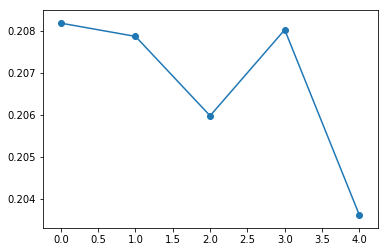

In [18]:
res = classifier_results.accuracies
all_stats = [
    [res[e_rbm][b_num] for b_num in res[e_rbm].keys()] for e_rbm in res.keys()
]
all_stats = np.array(all_stats).flatten()
ymn, ymx = all_stats.min(), all_stats.max()

med_stats = [
    [np.median(res[e_rbm][b_num]) for b_num in res[e_rbm].keys()] for e_rbm in res.keys()
]
med_stats = np.array(med_stats).mean(axis=1)
print(med_stats.shape)

xs = range(len(med_stats))
plt.plot(xs, med_stats)
plt.scatter(xs, med_stats)
plt.show()


# for epoch_rbm in res.keys():
#     r = res[epoch_rbm]

#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
#     for a, b_num in zip([ax1, ax2, ax3], r.keys()):
#         a.set_title('RBM_epo=%d; batch_num=%d' % (epoch_rbm, b_num))
#         a.set_ylim([ymn, ymx])

#     xs = range(len(r[0]))
#     ax1.plot(xs, r[0])
#     ax2.plot(xs, r[20])
#     ax3.plot(xs, r[40])

#     plt.show()

# DRBM